# Yelp Restaurant Review Clustering System

### Load Business File

In [ ]:
def file_open(file_name):
    json_data = ''
    with open(file_name, 'r', encoding='utf-8') as in_file:
        for i, line in enumerate(in_file):
            if i == 0 and line: 
                json_data += '[' + line
            elif line:
                json_data += ',' + line
            else:
                pass
        json_data += ']\n'
    
    data = json.loads(json_data)
    df = json_normalize(data)
    return df

In [3]:
import json 
import pandas as pd 
import numpy as np
from pandas.io.json import json_normalize #package for flattening json in pandas df

%time df = file_open('business.json')

CPU times: user 21 s, sys: 1.02 s, total: 22 s
Wall time: 22.6 s


In [182]:
## Keep Some Useful Column
keeps = ['name', 'stars', 'categories', 'review_count', 'business_id']
business_df = df[keeps]
business_df.head() 

,name,stars,categories,review_count,business_id
0,Arizona Biltmore Golf Club,3.0,"Golf, Active Life",5,1SWheh84yJXfytovILXOAQ
1,Emerald Chinese Restaurant,2.5,"Specialty Food, Restaurants, Dim Sum, Imported...",128,QXAEGFB4oINsVuTFxEYKFQ
2,Musashi Japanese Restaurant,4.0,"Sushi Bars, Restaurants, Japanese",170,gnKjwL_1w79qoiV3IC_xQQ
3,Farmers Insurance - Paul Lorenz,5.0,"Insurance, Financial Services",3,xvX2CttrVhyG2z1dFg_0xw
4,Queen City Plumbing,4.0,"Plumbing, Shopping, Local Services, Home Servi...",4,HhyxOkGAM07SRYtlQ4wMFQ


### Get all Business ID in Restaurant Catag. 

In [5]:
temp = business_df.categories.apply(lambda categories: str(categories))
restaurant_df = business_df[temp.apply(lambda categories: 'Restaurants' in categories)][['categories',"business_id"]]
restaurant_df.head()
# from https://stackoverflow.com/questions/52346296/pandas-dataframe-apply-typeerror-argument-of-type-float-is-not-iterable

,categories,business_id
1,"Specialty Food, Restaurants, Dim Sum, Imported...",QXAEGFB4oINsVuTFxEYKFQ
2,"Sushi Bars, Restaurants, Japanese",gnKjwL_1w79qoiV3IC_xQQ
11,"Restaurants, Breakfast & Brunch, Mexican, Taco...",1Dfx3zM-rW4n-31KeC8sJg
13,"Italian, Restaurants, Pizza, Chicken Wings",fweCYi8FmbJXHCqLnwuk8w
17,"Restaurants, Italian",PZ-LZzSlhSe9utkQYU8pFg


In [6]:
business_id = restaurant_df.business_id
business_id.head()

1     QXAEGFB4oINsVuTFxEYKFQ
2     gnKjwL_1w79qoiV3IC_xQQ
11    1Dfx3zM-rW4n-31KeC8sJg
13    fweCYi8FmbJXHCqLnwuk8w
17    PZ-LZzSlhSe9utkQYU8pFg
Name: business_id, dtype: object

In [7]:
# Read Review File

%time review_df = file_open('review.json')
#review_df = pd.read_json("review.json", lines=True)
#review_df.head

CPU times: user 4min 21s, sys: 3min 56s, total: 8min 17s
Wall time: 12min 5s


### Get Review Data in Restaurant Field. 

In [8]:
%time res_review = pd.merge(review_df,restaurant_df,on = 'business_id', how = 'left', sort = False)
res_review=res_review.fillna(0)

CPU times: user 40.8 s, sys: 3min 24s, total: 4min 5s
Wall time: 7min 14s


In [9]:
res_review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,categories
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA,0
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg,0
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw,0
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg,"Bars, Pubs, Nightlife, Tapas Bars, Restaurants"
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ,0


In [10]:
%time restaurant_review=res_review[res_review.categories!=0]
restaurant_review.shape

CPU times: user 4.31 s, sys: 19.5 s, total: 23.8 s
Wall time: 39.4 s


(4201684, 10)

### Text Cleaning & Generate Phrases

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [187]:
import re
import string
char_splitter = re.compile("[.,;!:()-]?")    # splitted by these puncuation    ex. "i mean it's taco bell", "so ~"
def generate_candidate_phrases(text, stopwords):
    coarse_candidates = char_splitter.split(text.lower())
    candidate_phrases = []
    #filtered_word = []
    word=""
    n=0
    for coarse_phrase in coarse_candidates:
        words=re.split("\\s+", coarse_phrase.strip())
        previous_stop = False
        start=True
        #print('words: ', words)
        for w in words:
            w=w.translate(str.maketrans('', '', string.punctuation))
            if w in stopwords and not previous_stop:

                # phrase boundary encountered, so put a hard indicator
                if n>1:          
                    ### phrase appended here ###
                    candidate_phrases.append(word)
                previous_stop = True
                word=""
                n=0
            elif w in stopwords and previous_stop:

                word=""
                n=0
            elif w not in stopwords and len(w) > 3:
                # keep adding words to list until a phrase boundary is detected
                
                if start==True:
                    n=1     
                    start=False
                elif previous_stop==False:
                    w="_"+w
                    n=n+1      # n continues non-stopword
                else:
                    n=1
                
                word+=w
                previous_stop = False


    if n>1:
        ### phrase appended here ###
        candidate_phrases.append(word)

    return candidate_phrases 

In [179]:
import spacy
sp = spacy.load('en') 
stop=list(sp.Defaults.stop_words) 
stop.append("said")
stop.append("came")
stop.append("tell")
stop.append("told")
stop.append("when")
stop.append("maybe")
stop.append("sure")
stop.append("like")
stop.append("it's")
stop.append("i'm")
stop.append("ask")
stop.append("asked")

In [180]:
##get phrases in each review
def get_phrases(test):
    p=[]
    for s in test:
        #phrases = generate_candidate_phrases(s,stop)
        #p.append(phrases)
        p.append(generate_candidate_phrases(s,stop))
    return p

In [ ]:
%time p = get_phrases(restaurant_review['text'])

### Start Building Word2Vec Model

In [65]:
#from gensim.models import Word2Vec
import gensim
model = gensim.models.Word2Vec(
        p,
        size=200,
        window=10,
        min_count=10,
        alpha=0.02,
        workers=10)
%time model.train(p, total_examples=len(p), epochs=20)

CPU times: user 44min 8s, sys: 27.7 s, total: 44min 35s
Wall time: 15min 24s


(426493854, 687270340)

In [68]:
model.save("word2vec.model")

In [183]:
#from gensim.models import Word2Vec
#model = Word2Vec.load("word2vec.model")

In [71]:
w1=['rude_staff']
model.wv.most_similar(w1)

[('rude_employees', 0.7338390350341797),
 ('zero_customer_service_skills', 0.7189843058586121),
 ('zero_customer_service', 0.7181423902511597),
 ('horrible_staff', 0.7154984474182129),
 ('worse_customer_service', 0.7120515704154968),
 ('rude_people', 0.7102500796318054),
 ('rude_owner', 0.7071900367736816),
 ('unprofessional_person', 0.706324577331543),
 ('rudest_person', 0.7057175636291504),
 ('staff_sucks', 0.7052751183509827)]

In [36]:
w1=['large_groups']
model.wv.most_similar(w1)

[('large_parties', 0.8030858039855957),
 ('large_party', 0.7886699438095093),
 ('larger_groups', 0.7379469871520996),
 ('small_groups', 0.7081803679466248),
 ('larger_party', 0.6992192268371582),
 ('long_table', 0.688779890537262),
 ('group_size', 0.6792962551116943),
 ('easily_accommodate', 0.6541699171066284),
 ('long_tables', 0.6538715362548828),
 ('accommodate_large_groups', 0.6448752880096436)]

### Enhance Clustering Model & Get Result Tags

In [322]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn import metrics
import numpy as np

def get_predict(businessid):
    test=res_review["text"][res_review.business_id==businessid]
    l=len(test)
    if l<10:
        return ([],[],[],[],0,0,0), l
    elif l<20:
        minspl=3
        eps=0.4
    elif l<80:
        minspl=3
        eps=0.35
    elif l<180:
        minspl=5
        eps=0.35
    elif l<500:
        minspl=6
        eps=0.35
    elif l<1000:
        minspl=10
        eps=0.35
    elif l<1500:
        minspl=12
        eps=0.35
    elif l<2000:
        minspl=15
        eps=0.35
    else:
        minspl=20
        eps=0.35
    #print('len: ', l, 'eps: ', eps, 'minspl: ', minspl)
    return prediction(test,eps,minspl), l

def prediction(test,eps,minspl):
    ##get data 
    p1 = []
    for s in test:
        p1.append(generate_candidate_phrases(s,stop))
    words=sum(p1,[])          # transfering phrases from 2D array to 1D array
    ##remove uncommon words
    candidates=[]
    for a in words:
        if a in model.wv:
            candidates.append(a)
            
    ##calculate similarity
    sim=[[0]*len(candidates) for _ in range(len(candidates))]    # create 0-based 2D array
    for i in range(len(candidates)):
        for j in range(i,len(candidates)):
            d=model.wv.similarity(candidates[i],candidates[j]) 
            d = (1 if d > 1 else d)
            d = (0 if d < 0 else d)
            sim[i][j] = d
            sim[j][i] = d
    sim=np.array(sim)
    dis = sim.copy()
    dis = 1. - dis
    
    ##DBSCAN
    db = DBSCAN(metric="precomputed",algorithm="brute",eps=eps, min_samples=minspl).fit(dis)
    db_labels = db.labels_
    db_core=db.core_sample_indices_
    db_n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)    # set() to merge repeated elements
    #print('db_n_clusters_: ', db_n_clusters_)
    
    Medoids_result = []

    if db_n_clusters_ <2:
        db_result = []
        DB_Score = 0
        Kmedoid_Score = 0
    else:
        db_result = get_result(db_n_clusters_, db_core, db_labels, candidates)
        
        Medoids_points, Medoids_labels = cluster(dis, db_n_clusters_)
        [Medoids_result.append(candidates[pts]) for pts in Medoids_points]
        
        DB_Score = metrics.silhouette_score(dis,db_labels)
        Kmedoid_Score = metrics.silhouette_score(dis,Medoids_labels)
        #print("DB_Score_type: ", type(DB_Score))
    ##AffinityPropagation
    Aff = AffinityPropagation(affinity='precomputed').fit(dis)
    Aff_core = Aff.cluster_centers_indices_
    Aff_result = []
    if Aff_core is None:     ## error handling
        Aff_result = []
        Aff_Score = 0
    elif len(Aff_core) > 1:
        Aff_n_clusters = len(set(Aff.labels_))
        Aff_labels = Aff.labels_
        Aff_result = get_result(Aff_n_clusters, Aff_core, Aff_labels, candidates)

        Aff_Score = metrics.silhouette_score(dis,Aff_labels)
        

    return db_result, Medoids_result, Aff_result, words, DB_Score, Kmedoid_Score, Aff_Score

    
def get_result(n_clusters_, core, labels, candidates):
    group=[[]*n_clusters_ for _ in range(n_clusters_)]   #create empty 2D array, (size : n_clusters_ * n_clusters_)
    for i in core:
        j=int(labels[i])
        group[j].append(candidates[i])         # getting each cluster's phrases
        #print("core_num: ", i, " ; candidates: ", candidates[i])
    result=[]
    for i in range(len(group)):
        re=group[i]
        if len(set(re))==1:         # set to merge same phrases of one row
            result.append(re[0])
        else:
            cnt = Counter(re)    # get each frequency and return most common one
            a=cnt.most_common(1)
            result.append(a[0][0])
    return result

In [320]:
## K-Medoid Function
import random
def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]     # horizontal, return minimum value's index
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)
def cluster(distances, k):
    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = []
        clusters = assign_points_to_clusters(curr_medoids, distances)
        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)
            
        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]
    return curr_medoids, clusters

In [305]:
for idx in business_id.index[108:120]:
    business_ID = business_id[idx]
    (result_DB, result_Medoid, result_Aff, words, A, B, C), review_count = get_predict(business_ID)
    print("result_DB", result_DB)

DB_Score_type:  <class 'numpy.float64'>
result_DB ['scallion_pancake', 'general_tsos']
DB_Score_type:  <class 'numpy.float64'>
result_DB ['cutest_coffee_shop', 'thrifty_cream']
result_DB []
result_DB []
DB_Score_type:  <class 'numpy.float64'>
result_DB ['restaurant_zero_stars', 'chinese_buffet', 'crab_legs', 'sink_area', 'best_chinese_food', 'chinese_food', 'crab_rangoons']
result_DB []
result_DB []
result_DB []
DB_Score_type:  <class 'numpy.float64'>
result_DB ['potato_salad', 'baked_potato', 'pulled_pork_sandwich', 'funnel_cake', 'fair_food', 'state_fair']
DB_Score_type:  <class 'numpy.float64'>
result_DB ['style_milk', 'recently_renovated', 'wonton_noodle_soup', 'cold_drink']
DB_Score_type:  <class 'numpy.float64'>
result_DB ['hello_bistro', 'mccandless_crossing', 'dont_know', 'grilled_cheese', 'ordered_online', 'long_time', 'eatn_park']
DB_Score_type:  <class 'numpy.float64'>
result_DB ['panera_bread', 'register_open']


### Evaluation Process

In [297]:
# get similarity between pharses in a result
def sim_eva(result):
    total_sim = 0
    itr_count = 0
    if len(result)<2:   #no phrase or one phrase
        return 0
    for idx1 in range(len(result)):
        for idx2 in range(idx1+1, len(result)):
            sim = model.wv.similarity(result[idx1],result[idx2])
            sim = (0 if sim<0 else sim)
            itr_count +=1
            total_sim += sim
    return total_sim/itr_count

In [191]:
'''def freq_eva(result, phrases):
    if len(result)==0:   #empty result
        return 0
    total_phrases_freq = 0
    phrase_dic = Counter(phrases)

    for p in result:
        total_phrases_freq += phrase_dic[p]

    return total_phrases_freq/len(result)

In [298]:
# count all similiar phrases that occurs
def freq_eva_v2(result, phrases):
    if len(result)==0:   #empty result
        return 0
    total_phrases_freq = 0
    phrase_dic = Counter(phrases)

    for p in result:
        
        top_related_phrases = model.wv.most_similar(p)
        
        for p2,sim in top_related_phrases:
        
            total_phrases_freq += phrase_dic[p2]
        
    return total_phrases_freq/len(result)

### Give N Random Business ID and Compute the Average of Similarity&Frequency

In [317]:
# run multiple business ID and get their average
def entire_eva(business_id):  
    sim_DB=0
    sim_Medoid=0
    sim_Aff=0
    
    freq_DB=0
    freq_Meoid=0
    freq_Aff=0
    
    DB_Score_Sum = 0
    Kmedoid_Score_Sum = 0
    Aff_Score_Sum = 0
    
    count = 0
    Total_Review = 0
    for i in random.sample(range(59371), 10):      # generate N random index (here 200)
        ID_Idx = business_id.index[i]
        business_ID = business_id[ID_Idx]
        (result_DB, result_Medoid, result_Aff, words, DB_Score, Kmedoid_Score, Aff_Score), review_count = get_predict(business_ID)
        #print("result_DB: ", result_DB)
        #print("result_Medoid: ", result_Medoid)
        #print("result_Aff: ", result_Aff)
        
        sim_DB += sim_eva(result_DB)
        sim_Medoid += sim_eva(result_Medoid)
        sim_Aff += sim_eva(result_Aff)
        
        freq_DB += freq_eva_v2(result_DB, words)
        freq_Meoid += freq_eva_v2(result_Medoid, words)
        freq_Aff += freq_eva_v2(result_Aff, words)
        
        DB_Score_Sum += DB_Score
        Kmedoid_Score_Sum += Kmedoid_Score
        Aff_Score_Sum += Aff_Score
        
        Total_Review +=review_count
        count += 1
        
    return sim_DB/count, freq_DB/count, sim_Medoid/count,\
            freq_Meoid/count, sim_Aff/count, freq_Aff/count, Total_Review/count,\
            DB_Score_Sum/count, Kmedoid_Score_Sum/count, Aff_Score_Sum/count

### Plot Evaluation Result 

In [346]:
import matplotlib.pyplot as plt
def eva_plot(Sim_List, Freq_List, Average_Review_Number, Score_List):
    plt.figure(figsize=(15, 5))
    plt.suptitle("Average Review Number: %d"%Average_Review_Number, fontsize=14)
    
    x_name = ["DBSCAN","Medoid","AffinityPropagation"]
    ax1 = plt.subplot(141)
    x1_value = Sim_List
    ax1.bar(x_name, x1_value, color=['lightskyblue','yellowgreen','grey'], width = 0.5)
    ax1.set_title("Average Similarity")

    ax2= plt.subplot(142)
    x2_value = Freq_List
    ax2.bar(x_name, x2_value, color=['lightskyblue','yellowgreen','grey'], width = 0.5)
    ax2.set_title("Frequency of Occurrence")

    ax3= plt.subplot(143)
    x3_value = Score_List
    ax3.bar(x_name, x2_value, color=['lightskyblue','yellowgreen','grey'], width = 0.5)
    ax3.set_title("Silhouette Coefficient Score")    
    
    ax4= plt.subplot(144)
    x =[0,1,2]

    ax4.bar(x, x1_value, width=0.3, label='similarity',tick_label = x_name ,fc = 'y')
    
    for i in range(len(x)):
        x[i] = x[i] + 0.5
    ax4.bar(x, x2_value, width=0.3, label='frequency', tick_label = x_name,fc = 'r')
    

    ax4.legend()

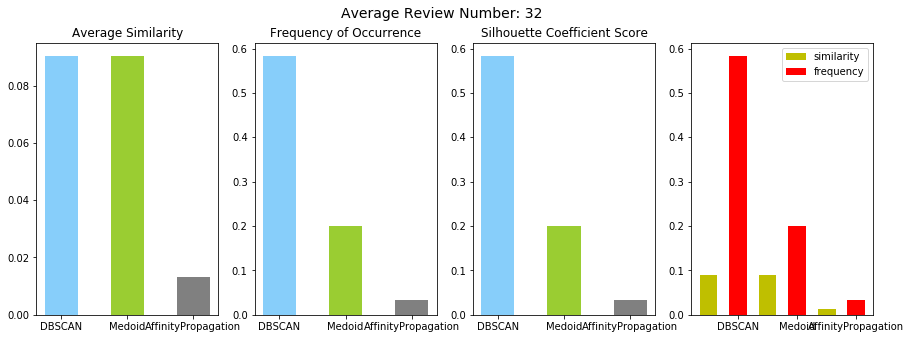

In [348]:
DB_sim_eva, DB_freq_eva, Medoid_sim_eva, Medoid_freq_eva, Aff_sim_eva,\
            Aff_freq_eva, Average_Review_Number, Avg_DB_Score, Avg_Kmedoid_Score, Avg_Aff_Score = entire_eva(business_id)
Sim_List = [DB_sim_eva, Medoid_sim_eva, Aff_sim_eva]
Freq_List = [DB_freq_eva, Medoid_freq_eva, Aff_freq_eva]
Score_List = [Avg_DB_Score, Avg_Kmedoid_Score, Avg_Aff_Score]
#print("Average DBSCAN Silhouette Coefficient Score: ", Avg_DB_Score)
#print("Average K-Medoids Silhouette Coefficient Score: ", Avg_Kmedoid_Score)
#print("Average AffinityPropagation Silhouette Coefficient Score: ", Avg_Aff_Score)
eva_plot(Sim_List, Freq_List, Average_Review_Number, Score_List)

#### 200 Random Business ID

CPU times: user 1h 26min 30s, sys: 8min, total: 1h 34min 30s
Wall time: 1h 36min 44s


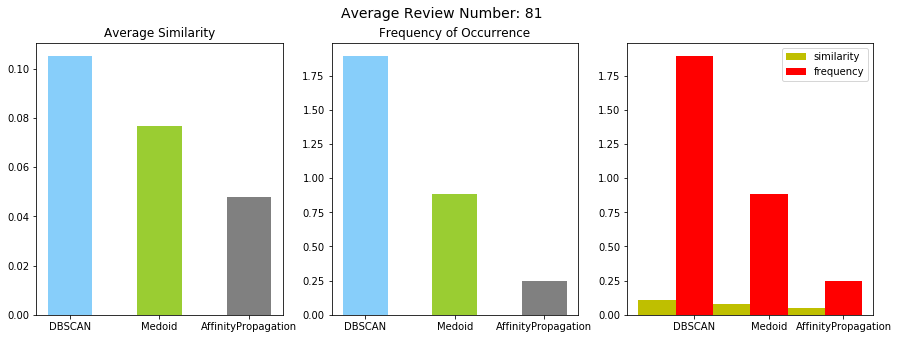

In [206]:
%time DB_sim_eva, DB_freq_eva, Medoid_sim_eva, Medoid_freq_eva, Aff_sim_eva,\
            Aff_freq_eva, Average_Review_Number = entire_eva(business_id)
Sim_List = [DB_sim_eva, Medoid_sim_eva, Aff_sim_eva]
Freq_List = [DB_freq_eva, Medoid_freq_eva, Aff_freq_eva]
eva_plot(Sim_List, Freq_List, Average_Review_Number)

CPU times: user 38min 2s, sys: 3min 19s, total: 41min 21s
Wall time: 45min 11s
Sim_List [0.13051796179230865, 0.09267380422675321, 0.04841947137333995]
Freq_List [2.97658658008658, 1.3004112554112552, 0.2627364486837921]
CPU times: user 36min 18s, sys: 3min 21s, total: 39min 40s
Wall time: 42min 54s
Sim_List [0.12996092381799276, 0.0948357950873754, 0.04794509057054123]
Freq_List [1.8749947712418298, 0.9097999999999999, 0.35138950326231894]
CPU times: user 11min 57s, sys: 57.6 s, total: 12min 54s
Wall time: 12min 56s
Sim_List [0.08775659015216501, 0.06947496665542183, 0.043951875851594366]
Freq_List [1.857397793263647, 1.167581881533101, 0.11250791528732704]
CPU times: user 13min 9s, sys: 58.5 s, total: 14min 8s
Wall time: 14min 28s
Sim_List [0.11648865227921763, 0.07484320319279755, 0.052071531335275874]
Freq_List [2.1875853035853035, 0.5680172912194189, 0.2346730961572482]
CPU times: user 3min 24s, sys: 4.44 s, total: 3min 28s
Wall time: 3min 8s
Sim_List [0.11376005717753074, 0.09150

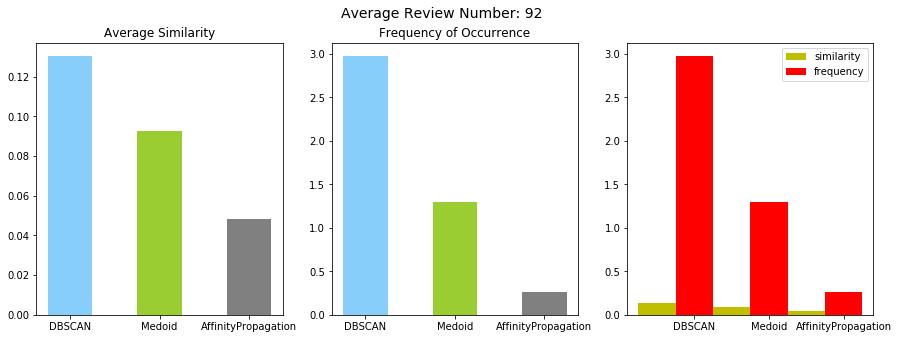

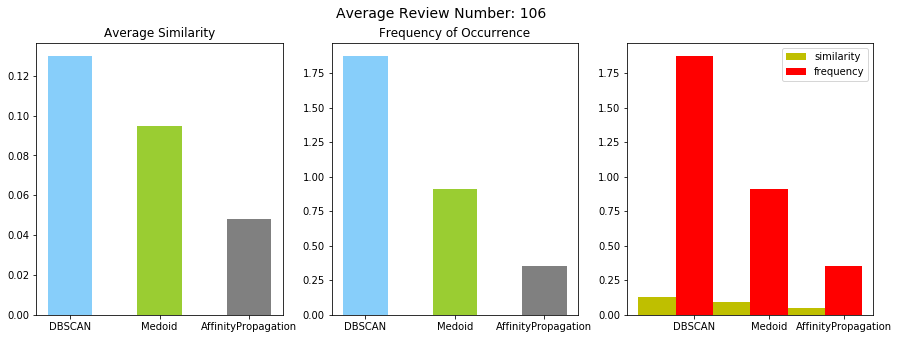

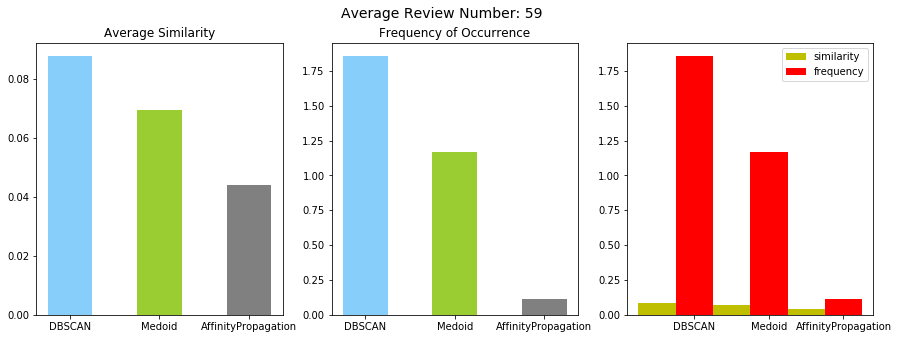

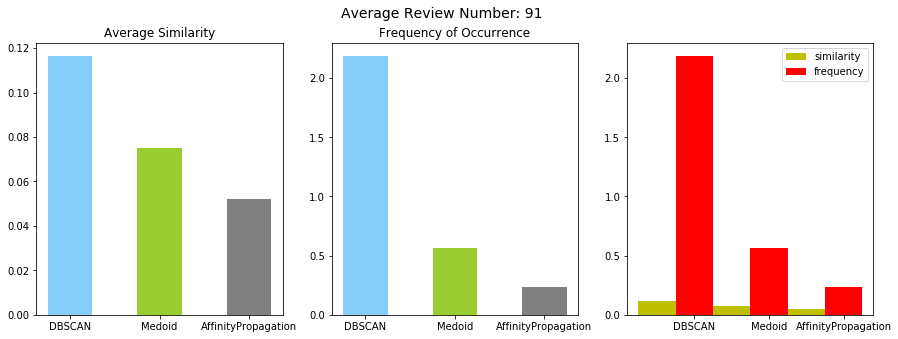

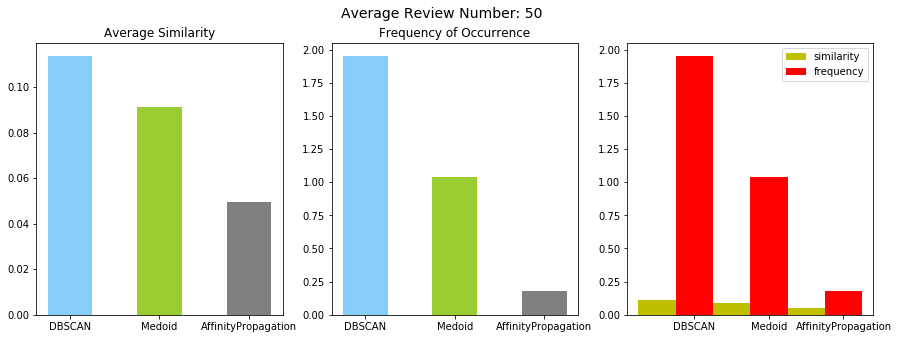

In [202]:
Sim_History = []
Freq_History = []
for i in range(5):
    %time DB_sim_eva, DB_freq_eva, Medoid_sim_eva, Medoid_freq_eva, Aff_sim_eva,\
            Aff_freq_eva, Average_Review_Number = entire_eva(business_id)
    Sim_List = [DB_sim_eva, Medoid_sim_eva, Aff_sim_eva]
    Freq_List = [DB_freq_eva, Medoid_freq_eva, Aff_freq_eva]
    
    print('Sim_List', Sim_List)
    print('Freq_List', Freq_List)
    
    Sim_History.append(Sim_List)
    Freq_History.append(Freq_List)
    
    eva_plot(Sim_List, Freq_List, Average_Review_Number)

CPU times: user 3min 3s, sys: 3.64 s, total: 3min 7s
Wall time: 3min 2s
Sim_List [0.12099958134500108, 0.06265565688744022, 0.04537379214796035]
Freq_List [1.7195238095238097, 0.6554761904761903, 0.15781421222597694]
CPU times: user 3min 5s, sys: 3.11 s, total: 3min 8s
Wall time: 2min 59s
Sim_List [0.09974268824242831, 0.09133444924066002, 0.05738120641231313]
Freq_List [1.5645421245421247, 0.6401902726902726, 0.19817218222826977]
CPU times: user 11min 35s, sys: 24.4 s, total: 12min
Wall time: 12min 47s
Sim_List [0.14284262270315157, 0.09486501688568522, 0.04235080350644823]
Freq_List [5.037301587301587, 1.900912698412699, 0.32074217383857895]
CPU times: user 2min 21s, sys: 3.28 s, total: 2min 24s
Wall time: 2min 40s
Sim_List [0.13657250746308514, 0.08507150191186666, 0.055971980738009686]
Freq_List [1.6642328042328043, 0.9114550264550265, 0.1382054691568085]


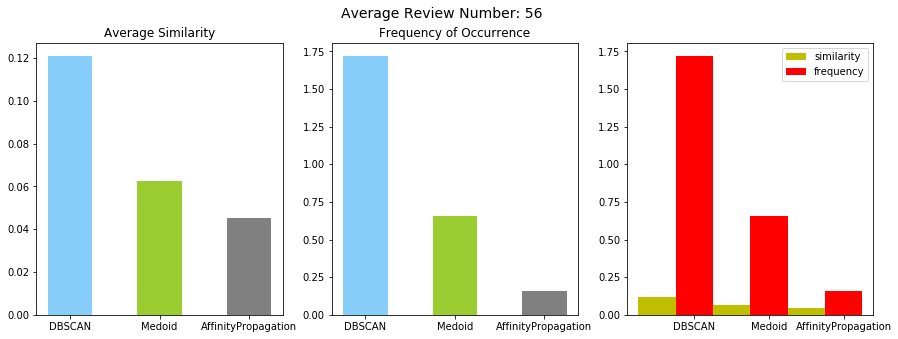

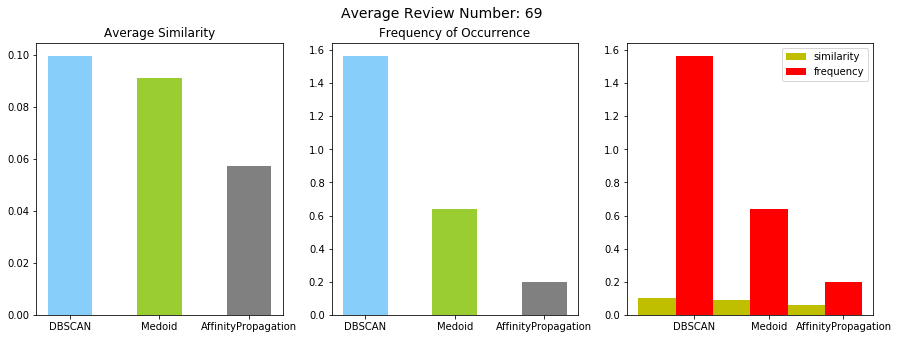

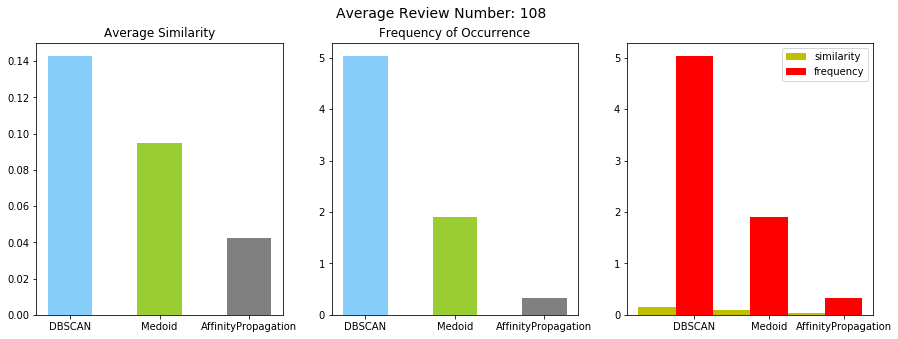

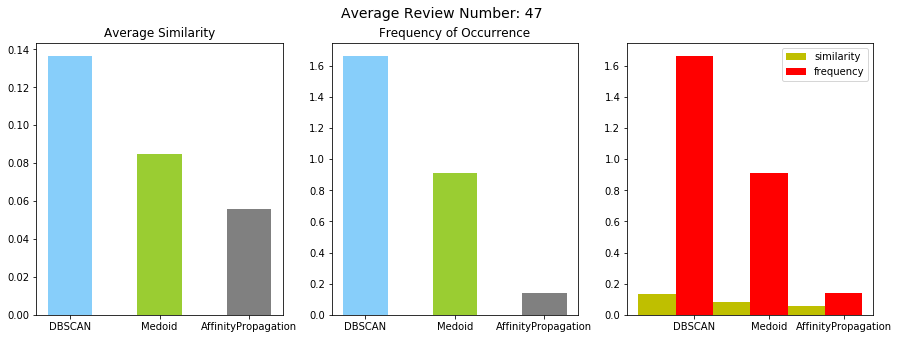

In [200]:
Sim_History = []
Freq_History = []
for i in range(4):
    %time DB_sim_eva, DB_freq_eva, Medoid_sim_eva, Medoid_freq_eva, Aff_sim_eva,\
            Aff_freq_eva, Average_Review_Number = entire_eva(business_id)
    Sim_List = [DB_sim_eva, Medoid_sim_eva, Aff_sim_eva]
    Freq_List = [DB_freq_eva, Medoid_freq_eva, Aff_freq_eva]
    
    print('Sim_List', Sim_List)
    print('Freq_List', Freq_List)
    
    Sim_History.append(Sim_List)
    Freq_History.append(Freq_List)
    
    eva_plot(Sim_List, Freq_List, Average_Review_Number)

CPU times: user 1min 40s, sys: 8.16 s, total: 1min 48s
Wall time: 1min 51s
Sim_List [0.10635549432785614, 0.07082829092991436, 0.04624440574673358]
Freq_List [0.9605555555555554, 0.49944444444444447, 0.21817921661671663]
CPU times: user 2min 17s, sys: 3.62 s, total: 2min 21s
Wall time: 2min 18s
Sim_List [0.1508662497175909, 0.08013605718589148, 0.04296715496707314]
Freq_List [2.8519444444444444, 1.2518055555555556, 0.206195104404302]
CPU times: user 1min 57s, sys: 4.39 s, total: 2min 1s
Wall time: 1min 58s
Sim_List [0.11541370900442069, 0.06601971659248064, 0.053292536248489175]
Freq_List [2.120833333333333, 0.5154761904761904, 0.28190319139672587]


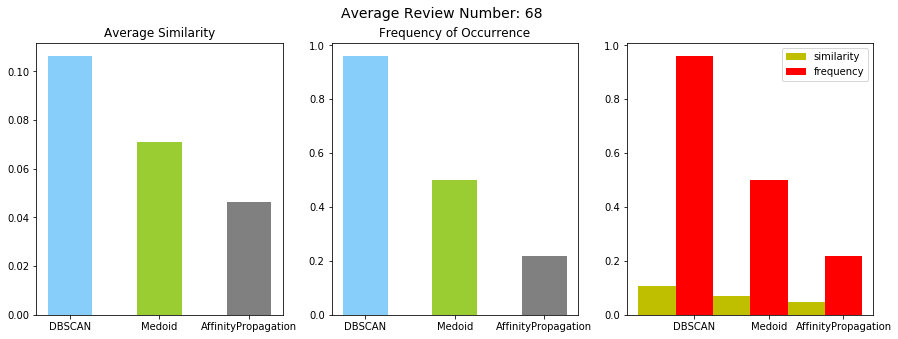

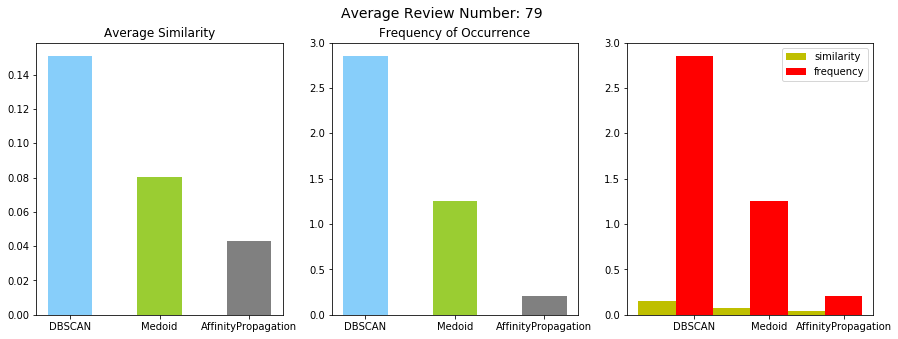

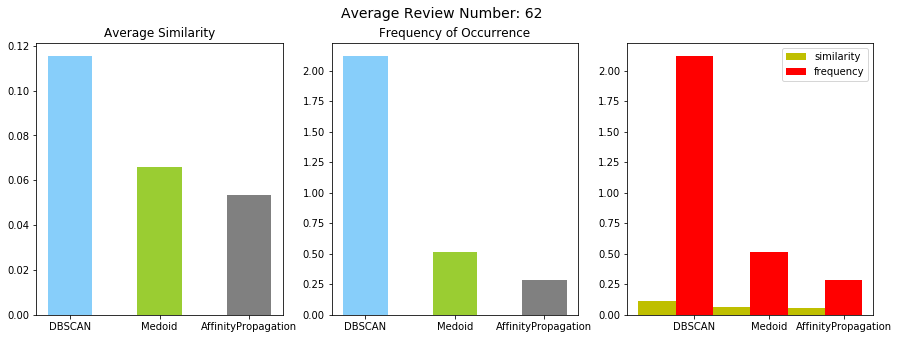

In [196]:
Sim_History = []
Freq_History = []
for i in range(3):
    %time DB_sim_eva, DB_freq_eva, Medoid_sim_eva, Medoid_freq_eva, Aff_sim_eva,\
            Aff_freq_eva, Average_Review_Number = entire_eva(business_id)
    Sim_List = [DB_sim_eva, Medoid_sim_eva, Aff_sim_eva]
    Freq_List = [DB_freq_eva, Medoid_freq_eva, Aff_freq_eva]
    
    print('Sim_List', Sim_List)
    print('Freq_List', Freq_List)
    
    Sim_History.append(Sim_List)
    Freq_History.append(Freq_List)
    
    eva_plot(Sim_List, Freq_List, Average_Review_Number)

CPU times: user 2min 58s, sys: 8.06 s, total: 3min 6s
Wall time: 3min 18s
CPU times: user 18.7 s, sys: 721 ms, total: 19.5 s
Wall time: 20.7 s
CPU times: user 41 s, sys: 1.1 s, total: 42.1 s
Wall time: 43.7 s


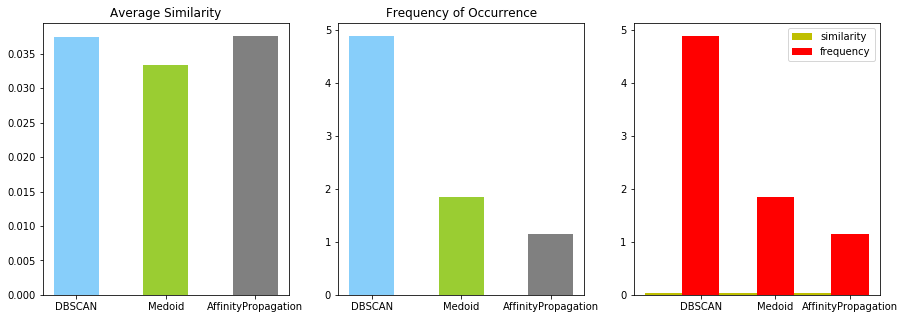

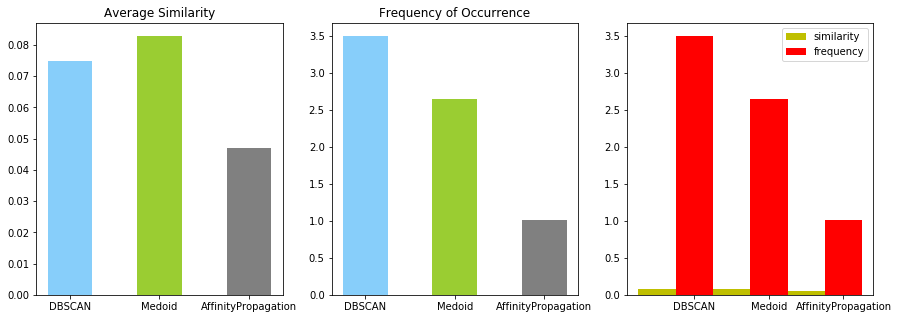

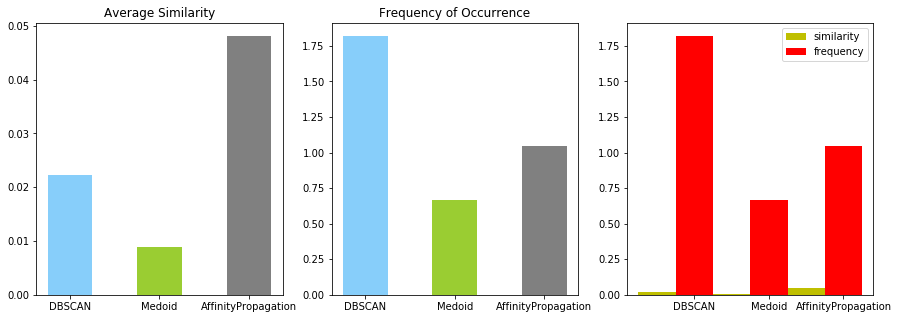

In [968]:
for i in range(3):
    %time DB_sim_eva, DB_freq_eva, Medoid_sim_eva, Medoid_freq_eva, Aff_sim_eva, Aff_freq_eva = entire_eva(business_id)
    Sim_List = [DB_sim_eva, Medoid_sim_eva, Aff_sim_eva]
    Freq_List = [DB_freq_eva, Medoid_freq_eva, Aff_freq_eva]
    eva_plot(Sim_List, Freq_List)

In [904]:
# random 10
print('dbscan average sim: ',DB_sim_eva)
print('dbscan average occurrence frequency: ',DB_freq_eva)
print('kmedoid average sim: ',Medoid_sim_eva)
print('kmedoid average occurrence frequency: ',Medoid_freq_eva)
print('AffinityPropagation average sim: ',Aff_sim_eva)
print('AffinityPropagation average occurrence frequency: ',Aff_freq_eva)

dbscan average sim:  0.13539281304478062
dbscan average occurrence frequency:  3.405555555555556
kmedoid average sim:  0.044302749719003776
kmedoid average occurrence frequency:  1.8616666666666668
AffinityPropagation average sim:  0.056406352932191164
AffinityPropagation average occurrence frequency:  1.0478835978835979


In [811]:
# 201~300 business
print('dbscan average sim: ',DB_sim_eva)
print('dbscan average occurrence frequency: ',DB_freq_eva)
print('kmedoid average sim: ',Medoid_sim_eva)
print('kmedoid average occurrence frequency: ',Medoid_freq_eva)
print('AffinityPropagation average sim: ',Aff_sim_eva)
print('AffinityPropagation average occurrence frequency: ',Aff_freq_eva)

dbscan average sim:  0.10364119557598162
dbscan average occurrence frequency:  3.672733260891156
kmedoid average sim:  0.07180642659511553
kmedoid average occurrence frequency:  1.4695075392443815
AffinityPropagation average sim:  0.044533510117039626
AffinityPropagation average occurrence frequency:  1.0692855337929583


In [783]:
# 5 business
print('dbscan average sim: ',DB_sim_eva)
print('dbscan average occurance frequency: ',DB_freq_eva)
print('kmedoid average sim: ',Medoid_sim_eva)
print('kmedoid average occurance frequency: ',Medoid_freq_eva)
print('AffinityPropagation average sim: ',Aff_sim_eva)
print('AffinityPropagation average occurance frequency: ',Aff_freq_eva)

dbscan average sim:  0.12619243029757965
dbscan average occurance frequency:  5.979012345679013
kmedoid average sim:  0.044199502079052
kmedoid average occurance frequency:  1.717283950617284
AffinityPropagation average sim:  0.05535020013876337
AffinityPropagation average occurance frequency:  1.107573539926481


In [690]:
# 11~20 business
print('dbscan average sim: ',DB_sim_eva)
print('dbscan average occurance frequency: ',DB_freq_eva)
print('kmedoid average sim: ',Medoid_sim_eva)
print('kmedoid average occurance frequency: ',Medoid_freq_eva)
print('AffinityPropagation average sim: ',Aff_sim_eva)
print('AffinityPropagation average occurance frequency: ',Aff_freq_eva)

dbscan average sim:  0.16627235469734583
dbscan average occurance frequency:  6.191975308641975
kmedoid average sim:  0.07297091711582732
kmedoid average occurance frequency:  1.8777777777777775
AffinityPropagation average sim:  0.05535020013876337
AffinityPropagation average occurance frequency:  1.107573539926481


In [553]:
# 100 business
print('dbscan average sim: ',DB_sim_eva)
print('dbscan average occurance frequency: ',DB_freq_eva)
print('kmedoid average sim: ',Medoid_sim_eva)
print('kmedoid average occurance frequency: ',Medoid_freq_eva)
print('AffinityPropagation average sim: ',Aff_sim_eva)
print('AffinityPropagation average occurance frequency: ',Aff_freq_eva)

dbscan average sim:  0.09088637088391487
dbscan average occurance frequency:  3.622353661754557
kmedoid average sim:  0.042527594823769214
kmedoid average occurance frequency:  1.4167624075980856
AffinityPropagation average sim:  0.04507472028895995
AffinityPropagation average occurance frequency:  1.0819425709993546


In [548]:
# 5 business
print('dbscan average sim: ',DB_sim_eva)
print('dbscan average occurance frequency: ',DB_freq_eva)
print('kmedoid average sim: ',Medoid_sim_eva)
print('kmedoid average occurance frequency: ',Medoid_freq_eva)
print('AffinityPropagation average sim: ',Aff_sim_eva)
print('AffinityPropagation average occurance frequency: ',Aff_freq_eva)

dbscan average sim:  0.22009123048817666
dbscan average occurance frequency:  4.1066666666666665
kmedoid average sim:  0.07086704601624425
kmedoid average occurance frequency:  2.0466666666666664
AffinityPropagation average sim:  0.03758353989880901
AffinityPropagation average occurance frequency:  1.1733333333333333


In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from collections import Counter
import numpy as np

def get_predict(businessid):
    test=res_review["text"][res_review.business_id==businessid]
    l=len(test)
    
    if l<60:
        minspl=3
        eps=0.25
    elif l<180:
        minspl=5
        eps=0.25
    elif l<500:
        minspl=8
        eps=0.25
    elif l<1000:
        minspl=10
        eps=0.25
    elif l<2000:
        minspl=12
        eps=0.25
    else:
        minspl=15
        eps=0.25
    #print('len: ', l, 'eps: ', eps, 'minspl: ', minspl)
    return prediction(test,eps,minspl), l

def prediction(test,eps,minspl):
    ##get data 
    p1 = []
    for s in test:
        p1.append(generate_candidate_phrases(s,stop))
    words=sum(p1,[])          # transfering phrases from 2D array to 1D array
    ##remove uncommon words
    candidates=[]
    for a in words:
        if a in model.wv:
            candidates.append(a)
            
    ##calculate similarity
    sim=[[0]*len(candidates) for _ in range(len(candidates))]    # create 0-based 2D array
    for i in range(len(candidates)):
        for j in range(i,len(candidates)):
            d=model.wv.similarity(candidates[i],candidates[j]) 
            d = (1 if d > 1 else d)
            d = (abs(d) if d<0 else d)
            sim[i][j] = d
            sim[j][i] = d
    sim=np.array(sim)
    dis = sim.copy()
    dis = 1. - dis

    ##DBSCAN
    db = DBSCAN(metric="precomputed",algorithm="brute",eps=eps, min_samples=minspl).fit(dis)
    db_labels = db.labels_
    db_core=db.core_sample_indices_
    #print('db_core: ', db_core)
    db_n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)    # set() to merge repeated elements
    #print('db_n_clusters_: ', db_n_clusters_)
    db_result = get_result(db_n_clusters_, db_core, db_labels, candidates)
    
    ## kMedoids
    Medoids_result = []
    Medoids_points = cluster(dis, db_n_clusters_)
    #[print(candidates[pts])for pts in Medoids_points]
    [Medoids_result.append(candidates[pts]) for pts in Medoids_points]
    
    ##AffinityPropagation
    Aff = AffinityPropagation(affinity='precomputed').fit(dis)

    Aff_core = Aff.cluster_centers_indices_
    
    if Aff_core is None:     ## error handling
        Aff_result = []
    else:
        Aff_n_clusters = len(set(Aff.labels_))
        Aff_labels = Aff.labels_
        Aff_result = get_result(Aff_n_clusters, Aff_core, Aff_labels, candidates)
    
    return db_result, Medoids_result, Aff_result, words

    
def get_result(n_clusters_, core, labels, candidates):
    group=[[]*n_clusters_ for _ in range(n_clusters_)]   #create empty 2D array, (size : n_clusters_ * n_clusters_)
    for i in core:
        j=int(labels[i])
        group[j].append(candidates[i])         # getting each cluster's phrases
        #print("core_num: ", i, " ; candidates: ", candidates[i])
    result=[]
    for i in range(len(group)):
        re=group[i]
        if len(set(re))==1:         # set to merge same phrases of one row
            result.append(re[0])
        else:
            cnt = Counter(re)    # get each frequency and return most common one
            a=cnt.most_common(1)
            result.append(a[0][0])
    return result

In [ ]:
'''import re
import string
from nltk.tag import *   
char_splitter = re.compile("[.,;!:()-]?")    # splitted by these puncuation    ex. "i mean it's taco bell", "so ~"
def generate_candidate_phrases_v2(text, stopwords):
    coarse_candidates = char_splitter.split(text.lower())
    candidate_phrases = []
    #filtered_word = []
    word=""
    n=0
    for coarse_phrase in coarse_candidates:
        #print("coarse_phrase: ", coarse_phrase)     
        #words=re.split("\\s+", coarse_phrase.strip())   
        tagged_sent = pos_tag(coarse_phrase.split())
        #print(tagged_sent)
        previous_adj = False
        previous_adv = False
        previous_stop = False
        start=True
        
        for w, pos in tagged_sent:

            if pos == "CD":     ##ignore digital word
                continue
                
            w=w.translate(str.maketrans('', '', string.punctuation))
            #print("word: ", w, " pos: ", pos)
            if w in stopwords and not previous_stop :

                # phrase boundary encountered, so put a hard indicator
                if n>1:          
                    ### phrase is here ###
                    #filtered_word.append(word.split("_"))
                    if "_" in word:
                        #print('add in candidate: ', word)              
                        candidate_phrases.append(word)
                previous_stop = True
                word=""
                n=0
            elif w in stopwords and previous_stop:

                word=""
                n=0
            elif w not in stopwords and len(w) > 3:
                # keep adding words to list until a phrase boundary is detected
                
                if start==True:
                    n=1     
                    start=False
                elif previous_stop==False:
                    
                    if pos in ["JJ", "JJR", 'JJS',"VBN", "VB", "VBD", "VBP", "VBZ"] and previous_adv:
                        previous_adj = False
                        w="_"+w
                    if pos in ['NN', 'NNS', 'NNP', 'NNPS', 'VBG'] and previous_adj:
                        previous_adj = False
                        w="_"+w
                    n=n+1      # n continues non-stopword
                else:
                    n=1
                
                if len(word)>1 and "_" in w:
                    word+=w
                
                ## first word in the phrase could be ADJ or ADV
                elif len(word)==0 and pos in ["JJ", "JJR", 'JJS',"VBN"]:  # ADJ
                    word = w
                    previous_adj = True
                    
                elif len(word)==0 and  pos in ["RB", "RBR", "RBS"]:  # ADV
                    word = w
                    previous_adv = True

                #print('word: ',word, 'n: ', n)
                previous_stop = False
            

    if n>1:
        ### phrase is here ###
        #filtered_word.append(word.split("_"))
        if "_" in word:
            #print('add in candidate: ', word)
            candidate_phrases.append(word)

    return candidate_phrases 